<a href="https://colab.research.google.com/github/utkuyucel/Deep-Learning/blob/master/Classification_V3_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!kaggle datasets download  "busra88/turkish-reviews-dataset"

 63% 9.00M/14.3M [00:00<00:00, 25.3MB/s]
100% 14.3M/14.3M [00:00<00:00, 32.4MB/s]


In [ ]:
!unzip turkish-reviews-dataset.zip

Archive:  turkish-reviews-dataset.zip
  inflating: Reviews.csv             


In [ ]:
!nvidia-smi

Tue Sep  8 16:51:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Embedding, Input, Conv1D, GlobalMaxPooling1D, Bidirectional, GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv("Reviews.csv")

df.head(5)

,Rating,Review
0,1,3 yıldır kullanıyorum ve memnunum:)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


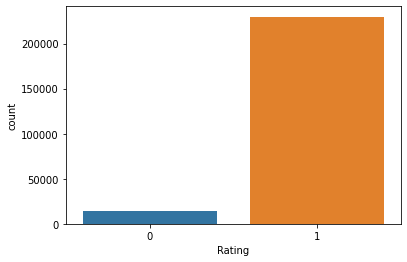

In [ ]:
sns.countplot(df.Rating)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243497 entries, 0 to 243496
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Rating  243497 non-null  int64 
 1   Review  243497 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [ ]:
den1 = (df["Rating"] == 0).sum()
den2 = (df["Rating"] == 1).sum()

den2/den1 #Shit

16.804694355074584

In [ ]:
import string

punc = string.punctuation

In [ ]:
def remove_punc(text):
  x = "".join([i for i in text if i not in punc])
  return x

In [ ]:
X = df.Review.astype(str)
Y = df.Rating

In [ ]:
X = X.apply(remove_punc)

In [ ]:
X[0]

'3 yıldır kullanıyorum ve memnunum'

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15)

In [ ]:
X_train

34468     Ürün güzel  menü hızlı Fakat beklentimin biraz...
57794                                                Güzel 
213809    Ürünü alalı yaklaşık 1 sene oldu tesadüfen res...
4529      Pratik ergonomik çok uygun fiyata tşk hepsibur...
35663     Ürünün ses kalitesi cidden üst düzeyEn yüksekt...
                                ...                        
240094                          güzel ürün tavsiye ederim  
62281     Bir hafta oldu yatağı alalı rulo halinde geliy...
159175    Özellikle geciktirici etkisi harikacinsel ilşk...
114851    balıkçılık ve av işlerinde işime yarar diye al...
75393                    Hiç kullanışlı değil Görseli güzel
Name: Review, Length: 206972, dtype: object

In [ ]:
max_words = 3000
max_len = 200
tokenizer = Tokenizer(num_words = max_words)

tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

In [ ]:
model = Sequential()

model.add(Embedding(max_words, 100, input_length= max_len))

model.add(Conv1D(256, 3, activation = "relu"))
model.add(Dropout(0.4))
model.add(Conv1D(512, 3, activation = "relu"))
model.add(Dropout(0.4))

model.add(GlobalMaxPooling1D())

model.add(Dense(16, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          300000    
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 256)          77056     
_________________________________________________________________
dropout (Dropout)            (None, 198, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 512)          393728    
_________________________________________________________________
dropout_1 (Dropout)          (None, 196, 512)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                8

In [ ]:
history = model.fit(sequences_matrix, Y_train, batch_size = 2048, epochs = 5)

Epoch 1/5
102/102 [==============================] - 31s 308ms/step - loss: 0.2135 - acc: 0.9411
Epoch 2/5
102/102 [==============================] - 31s 306ms/step - loss: 0.1163 - acc: 0.9566
Epoch 3/5
102/102 [==============================] - 31s 305ms/step - loss: 0.0973 - acc: 0.9644
Epoch 4/5
102/102 [==============================] - 31s 305ms/step - loss: 0.0878 - acc: 0.9681
Epoch 5/5
102/102 [==============================] - 31s 306ms/step - loss: 0.0805 - acc: 0.9711


In [ ]:
model.save("model_equal.h5")

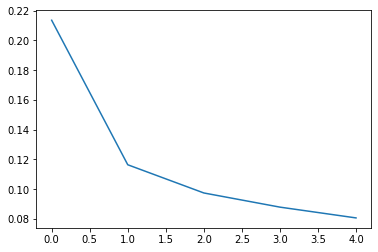

In [ ]:
plt.plot(history.history["loss"])

In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen = max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix, Y_test)
print("Accuracy on test set", accr[1])
print("Loss on test set", accr[0])

1142/1142 [==============================] - 4s 3ms/step - loss: 0.1090 - acc: 0.9625
Accuracy on test set 0.9624914526939392
Loss on test set 0.1090472862124443


In [ ]:
def eval(test, text_based_review = True):

  test2 = tokenizer.texts_to_sequences([test])
  test2_sequences_matrix = sequence.pad_sequences(test2, maxlen = max_len)
  
  predictions = model.predict(test2_sequences_matrix)

  if text_based_review == True:

    if predictions < 0.50:
      print("Negatif: ", predictions[0][0])
    
    else:
      print("Pozitif: ", predictions[0][0])

  else:
    return predictions[0][0]

In [ ]:
eval("ananızı sikeyim sizin")

Negatif:  0.38881096


In [ ]:
eval("orospu çocukları")

Pozitif:  0.65665346


In [ ]:
eval("çok beğendim ancak teknik destek çok zayıf")

Pozitif:  0.72303754


In [ ]:
eval("siktirin gidin")

Pozitif:  0.65665346


In [ ]:
eval("kargoda kırıldı. bok gibi")

Negatif:  0.17843556


In [ ]:
eval("amın oğlu")

Pozitif:  0.65665346
